# Navigation Deep Q-Network (DQN)
---
Implementing a DQN agent that picks up yellow bananas using Unity ML environments.

### Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
from navigation_agent_dqn import Agent
import navigation_model

### Instantiate the Environment

Initialize the environment in the code cell below.

In [2]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
act_size = brain.vector_action_space_size
print('Number of actions:', act_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
st_size = len(state)
print('States have length:', st_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Take Random Actions in the Environment

The next code cell shows how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you can see the agent's performance and if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [4]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(act_size)           # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### Agent Initialization and Training

Based on the DQN algorithm, this agent is trained using two neural network defined in `model.py`. The network has 2 hidden layer with 64 units, and an output layer with `act_size` units. A drop_out of 25% is used. 

In [12]:
agent = Agent(state_size=st_size, action_size=act_size, seed=4, drop_p=0.25)

Episode 100	Average Score: 1.01
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.26
Episode 400	Average Score: 10.94
Episode 448	Average Score: 13.02
Environment solved in 348 episodes!	Average Score: 13.02


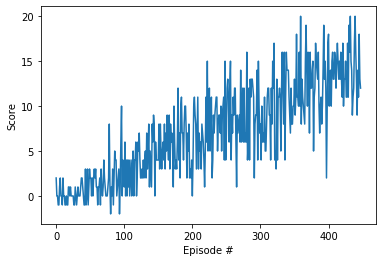

<Figure size 432x288 with 0 Axes>

In [13]:
def dqn(n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent_mode = 'train'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        agent_mode (string): to evaluate if an agent is in train_mode.
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        # Each episode will be terminated after max_t steps if terminal state is not reached before.
        for t in range(max_t): 
            # Choose an action based on the current state and epsilon.
            action = agent.act(state, eps)
            # Evaluate the enviroment with the previously selected action
            # and collect next_state, reward and flag for terminal state.
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            # Add experience tuple to memory buffer, and if enough samples are
            # in the buffer, train agent.
            if agent_mode == 'train': 
                agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            # If we reach the target score we break from the loop and save the qnetwork_local model parameters 
            # into a dictionary called 'checkpoint.pth'. This is done with the method torch.save
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_navigation.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('learning_curve.png', dpi = 500)

### Test the Agent

In [14]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_navigation.pth'))
                                         
scores = []                                            # initialize the score

for i in range(100):
    score = 0 
    env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    
    while True:
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores.append(score)
#     print("Score: {}, Episode: {} ".format(score, i), end="")
    print('\rScore {0:5.2f}, \tEpisode: {1:3d}'.format(score, i),end="")
    
print("\nAverage Score: {}".format(np.mean(np.asarray(scores))))

Score 19.00, 	Episode:  99
Average Score: 14.64


In [15]:
env.close()